Text(0.5, 1.0, 'geometry of sensors, source, and grid')

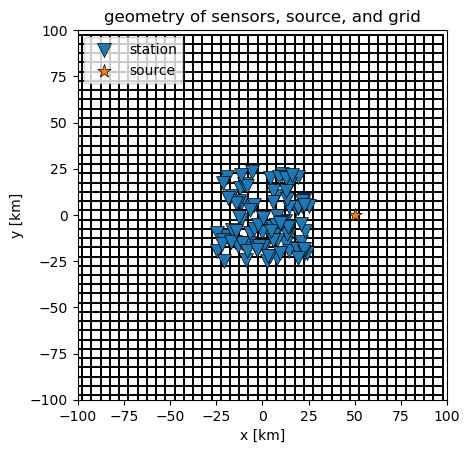

In [1]:
from itertools import product

import pylab as plt
import torch

torch.manual_seed(42)

# geometry of the problem
n_sensors = 100
# uniform random distribution in [-25, 25]
stations = torch.rand((n_sensors, 2)) * 50
stations -= 25
source = torch.tensor([50, 0])

# generate grid points
grid_limit = 100
grid_spacing = 5
grid_coords = torch.arange(-grid_limit, grid_limit, grid_spacing)
gridpoints = torch.tensor(list(product(grid_coords, repeat=2)))

# generate empty grid cells for visulation
xx, yy = torch.meshgrid(grid_coords, grid_coords, indexing="xy")
empty_cells = torch.zeros_like(xx) * torch.nan

# plotting
fig, ax = plt.subplots(1)
ax.pcolormesh(xx, yy, empty_cells, ec="k", lw=0.01)
ax.scatter(*stations.T, marker="v", s=100, label="station", ec='k', lw=0.5)
ax.scatter(*source, marker="*", s=100, label="source", ec='k', lw=0.5)
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_aspect("equal")
ax.legend(loc=2)
ax.set_xlabel("x [km]")
ax.set_ylabel("y [km]")
ax.set_title("geometry of sensors, source, and grid")

Text(0.5, 1.0, '(synthetic) recordings on sensors')

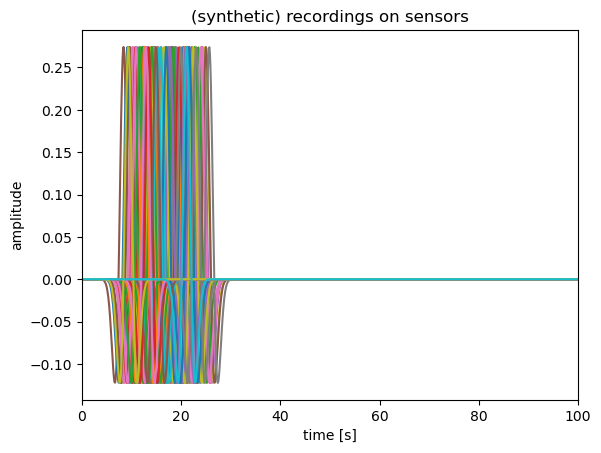

In [2]:
from scipy.signal import ricker

# define time
window_length = 100
sampling_rate = 10
times = torch.arange(0, window_length + 1 / sampling_rate, 1 / sampling_rate)

# compute frequencies
freqs = torch.fft.fftfreq(len(times), 1 / sampling_rate)
omega = 2 * torch.pi * freqs

# define medium
# acoustic homogeneous half-space
medium_velocity = 3

# compute travel times
distances = torch.linalg.norm(stations - source, axis=1)
traveltimes = distances / medium_velocity

# define source wavelet
wavelet = torch.fft.fft(torch.from_numpy(ricker(len(times), sampling_rate)))

# compute waveforms for all stations for given source
# Green's functions are exp(-iωt)
# waveforms are only computed for plotting purposes.
# In a usual field data application, waveforms already exist
# and waveform_spectra need to be computed.
waveform_spectra = wavelet * torch.exp(-1j * omega[None, :] * traveltimes[:, None])
waveforms = torch.fft.fftshift(torch.fft.ifft(waveform_spectra, axis=1).real)

# plotting
fig, ax = plt.subplots(1)
ax.plot(times, waveforms.T)
ax.set_xlim(0, window_length)
ax.set_xlabel("time [s]")
ax.set_ylabel("amplitude")
ax.set_title ("(synthetic) recordings on sensors")


In [3]:
# DASK VERSION

import dask.array as da
import numpy as np

# Frequency band to use for beamform
fmin, fmax = 0.1, 1.0

# theoretical traveltimes between all stations and all grid points
# Note that in this demonstration we know the velocity of the medium.
# In a field data application, medium_velocity may be another dimension to test.
# In that case, you can keep changes to the remaining logic minimal by
# keeping traveltimes as 1D tensor, i.e., with contents (gp1_v1, gp1_v2, ... gpN_vN-1, gpN_vN).
distances_to_all_gridpoints = torch.linalg.norm(
    gridpoints[:, None, :] - stations[None, :, :], axis=2
)
traveltimes = distances_to_all_gridpoints / medium_velocity

# limit to frequency band of interest for
# a) speed-up
# b) focusing on specific frequencies
freq_idx = torch.where((freqs > fmin) & (freqs < fmax))[0]
omega_lim = omega[freq_idx]
waveform_spectra_lim = waveform_spectra[:, freq_idx]

# Green's functions between all stations and all grid points
# within selected frequency band
# G = exp(-iωt)
greens_functions = torch.exp(-1j * omega_lim[None, None, :] * traveltimes[:, :, None])

# move critical part to dask
greens_functions_dask = da.from_array(greens_functions.numpy(), chunks=(100, 100, 100))

S = (
    greens_functions_dask[:, :, None, :]
    * greens_functions_dask.conj()[:, None, :, :]
)

# this assumes that K can be computed without memory issues.
# If this is not the case, you can also use dask and chunk K.
K = waveform_spectra_lim[:, None, :] * waveform_spectra_lim.conj()[None, :, :]

# exclude autocorrelations by filling diagonal with complex zeros
diag_idxs = torch.arange(K.shape[0])
zero_spectra = torch.zeros(omega_lim.shape, dtype=torch.cdouble)
K[diag_idxs, diag_idxs, :] = zero_spectra

K = da.from_array(K.numpy())

beampowers_d = da.einsum("gjiw, ijw -> g", S, K).real

beampowers = beampowers_d.compute()


Text(0.5, 1.0, 'beamforming output')

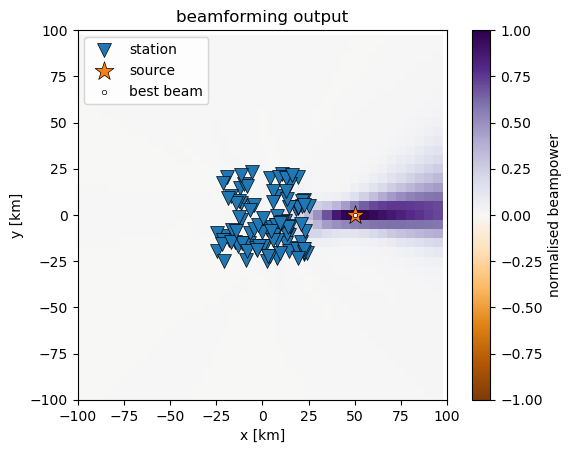

In [4]:
# plot beamforming result
fig, ax = plt.subplots(1)

bp = beampowers.reshape(len(grid_coords), len(grid_coords))
bp /= abs(bp).max()
pcm = ax.pcolormesh(xx, yy, bp.T, cmap="PuOr", vmin=-1, vmax=1)
ax.scatter(*stations.T, marker="v", s=100, label="station", ec='k', lw=0.5)
ax.scatter(*source, marker="*", s=200, label="source", ec='k', lw=0.5)
ax.scatter(
    *gridpoints[bp.argmax()],
    marker="o",
    ec="k",
    lw=0.5,
    c="w",
    s=10,
    label="best beam",
)
# ax.pcolormesh(xx, yy, empty_cells, ec="k", lw=0.1, alpha=0.5)
plt.colorbar(pcm, label="normalised beampower")
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_aspect("equal")
ax.legend(loc=2)
ax.set_xlabel("x [km]")
ax.set_ylabel("y [km]")
ax.set_title("beamforming output")